In [ ]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=180c0049fac5e8649bfe807c76a084f4bd4daa4bbffca3aff872c9601c5e141d
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [ ]:
import os
import re
from pathlib import Path
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem.lancaster import LancasterStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')
from collections import Counter
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.exceptions import ConvergenceWarning
import numpy as np
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  
import random
import wget
random.seed()
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
filename = wget.download("https://github.com/MIE451-1513-2019/course-datasets/raw/master/20_newsgroups.zip", "20_newsgroups.zip")
!unzip 20_newsgroups.zip
DATA_DIR = "20_newsgroups"

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: 20_newsgroups/talk.politics.guns/54127  
  inflating: 20_newsgroups/talk.politics.guns/53302  
  inflating: 20_newsgroups/talk.politics.guns/54315  
  inflating: 20_newsgroups/talk.politics.guns/54771  
  inflating: 20_newsgroups/talk.politics.guns/54543  
  inflating: 20_newsgroups/talk.politics.guns/55233  
  inflating: 20_newsgroups/talk.politics.guns/55039  
  inflating: 20_newsgroups/talk.politics.guns/54749  
  inflating: 20_newsgroups/talk.politics.guns/55234  
  inflating: 20_newsgroups/talk.politics.guns/54782  
  inflating: 20_newsgroups/talk.politics.guns/54544  
  inflating: 20_newsgroups/talk.politics.guns/54312  
  inflating: 20_newsgroups/talk.politics.guns/54120  
  inflating: 20_newsgroups/talk.politics.guns/53305  
  inflating: 20_newsgroups/talk.politics.guns/54915  
  inflating: 20_newsgroups/talk.politics.guns/54129  
  inflating: 20_newsgroups/talk.politics.guns/54586  
  inflating: 20_newsgroups/talk.politics.guns/54324  
 

## Functions from lab

In [ ]:
def clean_file_text(text):
    new_text = re.sub("Newsgroups:.*?\n", "", text)
    new_text = re.sub("Xref:.*?\n", "", new_text)
    new_text = re.sub("Path:.*?\n", "", new_text)
    new_text = re.sub("Date:.*?\n", "", new_text)
    new_text = re.sub("Followup-To:.*?\n", "", new_text)
    return new_text

In [ ]:
def corpus_count_words(file_list):
    tokenizer = RegexpTokenizer(r'\w+')
    word_counter = Counter()
    for file_path in file_list:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
            file_data = file.read()
            file_data = clean_file_text(file_data)
            file_words = tokenizer.tokenize(file_data)
            word_counter.update(file_words)
    return word_counter

In [ ]:
def get_topic_name(file_path):
    return file_path.parent.name

def get_target(topic_name):
    topics = ['talk.politics.mideast', 'rec.autos', 'comp.sys.mac.hardware', 'alt.atheism', 'rec.sport.baseball', 
     'comp.os.ms-windows.misc', 'rec.sport.hockey', 'sci.crypt', 'sci.med', 'talk.politics.misc', 
     'rec.motorcycles', 'comp.windows.x', 'comp.graphics', 'comp.sys.ibm.pc.hardware', 'sci.electronics',
     'talk.politics.guns', 'sci.space', 'soc.religion.christian', 'misc.forsale', 'talk.religion.misc']
    return topics.index(topic_name)

In [ ]:
def plot_confusion_matrix(cm):
    # plot the confusion matrix
    plt.figure(figsize=(10,10))
    plt.matshow(cm, fignum=1)
    
    # add labels for all targets
    num_targets = cm.shape[0]
    plt.xticks(list(range(num_targets+1)))
    plt.yticks(list(range(num_targets+1)))

## Q1

In [ ]:
all_files = [pth for pth in Path(DATA_DIR).glob("**/*") if pth.is_file() and not pth.name.startswith(".")]

In [ ]:
def binary_baseline_data(file_list, num_words = 1000): #binary encoding for 1000 most common words
    # Calculate word count in corpus
    news_cnt = corpus_count_words(file_list)
    
    # Select the most common numWords
    word_list = [word for (word, freq) in news_cnt.most_common(num_words)]
    
    # Create a binary encoding of dataset based on the selected features (X)
    tokenizer = RegexpTokenizer(r'\w+')
    df_rows = []
    for file_path in file_list:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
            file_data = file.read()
            file_data = clean_file_text(file_data)
            file_words = tokenizer.tokenize(file_data)
            df_rows.append([1 if word in file_words else 0 for word in word_list])      
    X = pd.DataFrame(df_rows, index=[str(f) for f in file_list], columns = word_list) #always include this index
    
    # Create a dataframe of targets (y)
    y = [get_target(get_topic_name(file_path)) for file_path in file_list]
    
    return X, y

In [ ]:
# get the baseline data
X_baseline, y_baseline = binary_baseline_data(all_files)

# split to train and test set
X_train, X_test, y_train, y_test = train_test_split(X_baseline, y_baseline, test_size=0.3, random_state=42)

# train a logistic regression classifier
clf = LogisticRegression(C=1.0).fit(X_train, y_train)

# predict on train and test set
y_train_predict = clf.predict(X_train)
y_test_predict = clf.predict(X_test)

# calculate train and test accuracy
train_accuracy = accuracy_score(y_train, y_train_predict)
test_accuracy = accuracy_score(y_test, y_test_predict)

# report results
print("Train accuracy: {}".format(train_accuracy))
print("Test accuracy: {}".format(test_accuracy))

Train accuracy: 0.9482031863970851
Test accuracy: 0.674


### Q1 (a)
*   Feature set: The 1000 most commonly words with binary encoding
*   The amount of data: 19997000 (19997 rows x 1000 columns)
*   Hyperparameter: C=1.0 (for logistic regression)

### Q1 (b)

Modify the following function:

In [ ]:
def binary_improved_data(file_list, num_words = 1000): #improve the feature set
    # Put your code here
    # Make sure you update the variable features and targets below
    
    # Calculate word count in corpus
    tokenizer = RegexpTokenizer(r'\w+')
    stemmer = LancasterStemmer()
    word_counter = Counter()
    for file_path in file_list:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
            file_data = file.read()
            file_data = clean_file_text(file_data)
            file_words = tokenizer.tokenize(file_data)
            file_words = [stemmer.stem(word) for word in file_words if not word in stopwords.words('english')]
            word_counter.update(file_words)
    
    # Select the most common numWords
    word_list = [word for (word, freq) in word_counter.most_common(num_words)]
    
    # Create a binary encoding of dataset based on the selected features (X)
    df_rows = []
    for file_path in file_list:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
            file_data = file.read()
            file_data = clean_file_text(file_data)
            file_words = tokenizer.tokenize(file_data)
            file_words = [stemmer.stem(word) for word in file_words]
            df_rows.append([1 if word in file_words else 0 for word in word_list])      
    X = pd.DataFrame(df_rows, index=[str(f) for f in file_list], columns = word_list) #always include this index
    
    # Create a dataframe of targets (y)
    y = [get_target(get_topic_name(file_path)) for file_path in file_list]

    #Please remember to put index for your dataframe as the file name
    #For example: pd.DataFrame(data, index=[str(f) for f in file_list],columns=[])
    
    # validate return types
    assert isinstance(X, pd.DataFrame) and isinstance(y, list), "return types"
    
    return X, y

### Q1 (c)

Modify the following partial code to calculate the train and test accuracy and answer the question in the markdown cell below

In [ ]:
# get the baseline data #call feature encoding, train and evaluate
X_binary_improved, y_binary_improved = binary_improved_data(all_files)

# Write your code here:
# You need to split the data and train a logistic regression classifier.
# Then, you need to calculate the variables train_accuracy and test_accuracy for the new classifier
# split to train and test set
X_train, X_test, y_train, y_test = train_test_split(X_binary_improved, y_binary_improved, test_size=0.3, random_state=42)

# train a logistic regression classifier
clf = LogisticRegression(C=1.0).fit(X_train, y_train)

# predict on train and test set
y_train_predict = clf.predict(X_train)
y_test_predict = clf.predict(X_test)

# calculate train and test accuracy
train_accuracy = accuracy_score(y_train, y_train_predict)
test_accuracy = accuracy_score(y_test, y_test_predict)


# report results
print("Train accuracy: {}".format(train_accuracy))
print("Test accuracy: {}".format(test_accuracy))

Train accuracy: 0.9663499321283132
Test accuracy: 0.7253333333333334


*   Train accuracy is increased from 0.948 to 0.966
*   Test accuracy is increased from 0.674 to 0.725

### Q1 (d)

Modify the partial code below

In [ ]:
def random_mean_ci(X, y, num_tests): #try different train_text split with diff random state
    # train_results is a list of train accuracy results for the differrent random splits of the dataset
    train_results = []
    
    # test_results is a list of test accuracy results for the differrent random splits of the dataset
    test_results = []
    
    # Write your code here
    for i in range(num_tests):
        # split to train and test set
        state = random.randint(1,1000)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=state)

        # train a logistic regression classifier
        clf = LogisticRegression(C=1.0).fit(X_train, y_train)

        # predict on train and test set
        y_train_predict = clf.predict(X_train)
        y_test_predict = clf.predict(X_test)

        # calculate train and test accuracy
        train_accuracy = accuracy_score(y_train, y_train_predict)
        test_accuracy = accuracy_score(y_test, y_test_predict)

        train_results.append(train_accuracy)
        test_results.append(test_accuracy)

    # calculate the train mean and the 95% confidence interval for the list of results
    train_mean = np.mean(train_results)
    train_ci_low, train_ci_high = stats.t.interval(0.95, len(train_results)-1, loc=train_mean, scale=stats.sem(train_results))
    
    # calculate the test mean and the 95% confidence interval for the list of results
    test_mean = np.mean(test_results)
    test_ci_low, test_ci_high = stats.t.interval(0.95, len(test_results)-1, loc=test_mean, scale=stats.sem(test_results))
    
    # validate return types
    assert isinstance(train_mean, float) and isinstance(train_ci_low, float) and isinstance(train_ci_high, float), "return types"
    assert isinstance(test_mean, float) and isinstance(test_ci_low, float) and isinstance(test_ci_high, float), "return types"
    
    return train_mean, train_ci_low, train_ci_high, test_mean, test_ci_low, test_ci_high

### Q1 (e)

Use the following code to calculate the mean accuracy and 95% confidence interval over 10 random splits

In [ ]:
train_mean10, train_low10, train_high10, test_mean10, test_low10, test_high10 = random_mean_ci(X_binary_improved, y_binary_improved, num_tests = 10)
print("Train mean accuracy over 10 random splits: {}".format(train_mean10))
print("Train confidence interval over 10 random splits: [{}, {}]".format(train_low10, train_high10))
print("Test mean accuracy over 10 random splits: {}".format(test_mean10))
print("Test confidence interval over 10 random splits: [{}, {}]".format(test_low10, test_high10))

Train mean accuracy over 10 random splits: 0.9654140172894191
Train confidence interval over 10 random splits: [0.9641468236997538, 0.9666812108790844]
Test mean accuracy over 10 random splits: 0.7334833333333333
Test confidence interval over 10 random splits: [0.7285802368954675, 0.7383864297711991]


The average tells the mean accuracy over 10 random splits(0.7 training size and 0.3 test size) for the model and the 95% confidence interval tells we have 95% confidence the accuracy will fall within this range for random splits. They are more informative than a single trial since they reduce the effect of data split on model performance. Different data splits can lead to different results, meaning it is not that robust. Therefore, we use these measures to reduce the occasionality.

### Q1 (f)

Modify the partial code below

In [ ]:
def random_cm(X, y, num_tests): #confusion matrix
    # cm_list is a list of confusion matrices for the different random splits of the dataset
    cm_list = []
    
    # Write your code here
    for i in range(num_tests):
        # split to train and test set
        state = random.randint(1,1000)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=state)

        # train a logistic regression classifier
        clf = LogisticRegression(C=1.0).fit(X_train, y_train)

        # predict on train and test set
        y_test_predict = clf.predict(X_test)

        cm = confusion_matrix(y_test, y_test_predict) #20x20 Confusion Matrix
        cm_list.append(cm) #List with 10 20x20 Matries

    # sum the confusion matrices and return the combined confusion matrix
    combined_cm = np.array(cm_list).sum(axis=0)

    # validate return type
    assert isinstance(combined_cm, np.ndarray), "return type"
    
    return combined_cm

### Q1 (g)

Use the following code to produce a confusion matrix for 10 random splits

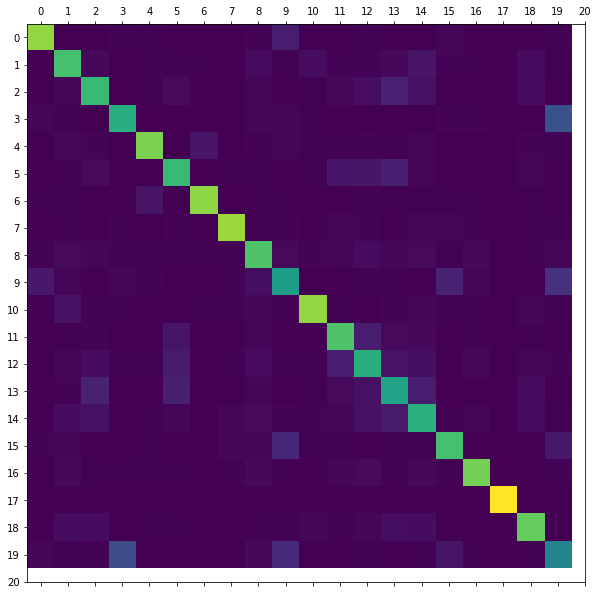

In [ ]:
cm10 = random_cm(X_binary_improved, y_binary_improved, num_tests = 10) #plot the confusion matrix
plot_confusion_matrix(cm10)

Yes, some classes are more easily confused with others. For example, class with index 3, 5, 9, 12, 13, 14, 19 are more easily confused since they have darker colors on the diagonal which means less samples are correctly predicted within these classes than the othe classes. For example, articles in class 13 and 14 are about computer hardware and electronic, which may be confusing.

## Q2

### Q2 (a)

Modify the partial code below

In [ ]:
def feature_num(X, y): #change the number of features
    # result_list is a list of tuples (num_features, train_accuracy, test_accuracy)
    # where numFeatures is the number of words used as features
    result_list = []
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    for p in [0.1, 0.2, 0.4, 0.6, 0.8, 1.0]:
        subset_size = int(p*X.shape[1]) #X.shape[1] = 1000
        X_train_subset = X_train.iloc[:, 0:subset_size]
        X_test_subset = X_test.iloc[:, 0:subset_size]
        # Write your code here to calculate train_accuracy and test_accuracy for the current subset of features
        # train a logistic regression classifier
        clf = LogisticRegression(C=1.0).fit(X_train_subset, y_train)

        # predict on train and test set
        y_train_predict = clf.predict(X_train_subset)
        y_test_predict = clf.predict(X_test_subset)

        # calculate train and test accuracy
        train_accuracy = accuracy_score(y_train, y_train_predict)
        test_accuracy = accuracy_score(y_test, y_test_predict)

        # add to result_list
        result_list.append((p, train_accuracy, test_accuracy))
        
    # Make a dataframe of the results
    result_df = pd.DataFrame(result_list, columns=["num_features", "train_accuracy", "test_accuracy"])
    
    # validate return type
    assert isinstance(result_df, pd.DataFrame), "return type"
    
    return result_df

### Q2 (b)

Use the following code to plot the train and test accuracy for the different feature sets sizes

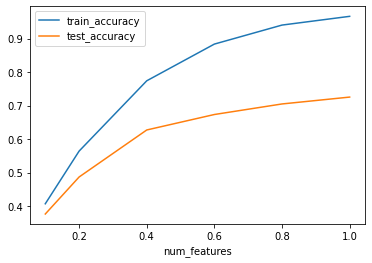

In [ ]:
feature_num_df = feature_num(X_binary_improved, y_binary_improved)
feature_num_df.plot(x="num_features", y=["train_accuracy", "test_accuracy"])

As the number of features used for training increases, both training and test accuracies increase as well. Also training accuracy is always higher than test accuracy.

## Q3

### Q3 (a)

Modify the partial code below

In [ ]:
def hyperparameter(X, y): #C is the hyperparameter for logistic regression, tune it
    # result_list is a list of tuples (num_features, train_accuracy, test_accuracy)
    # where numFeatures is the number of words used as features
    result_list = []
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    for param in [0.001, 0.01, 0.1, 1, 10, 100, 1000]:
        # Write your code here to calculate train_accuracy and test_accuracy for the current parameter value
        # train a logistic regression classifier
        clf = LogisticRegression(C=param).fit(X_train, y_train)

        # predict on train and test set
        y_train_predict = clf.predict(X_train)
        y_test_predict = clf.predict(X_test)

        # calculate train and test accuracy
        train_accuracy = accuracy_score(y_train, y_train_predict)
        test_accuracy = accuracy_score(y_test, y_test_predict)
        
        # add to result_list
        result_list.append((param, train_accuracy, test_accuracy))
        
    # Make a dataframe of the results
    result_df = pd.DataFrame(result_list, columns=["param", "train_accuracy", "test_accuracy"])
    
    # validate return type
    assert isinstance(result_df, pd.DataFrame), "return type"
    
    return result_df

### Q3 (b)

Use the following code to plot the train and test accuracy for the different the parameters

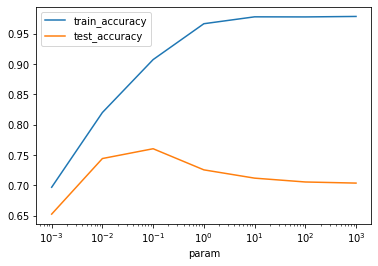

In [ ]:
param_df = hyperparameter(X_binary_improved, y_binary_improved)
param_df.plot(x="param", y=["train_accuracy", "test_accuracy"], logx=True)

As the hyperparameter C increases, training accuracy increases then remains stable while test accuracy increases to its maximum value with C=10^(-1) then starts decreasing.

## Q4

### Q4 (a)

Modify the partial code below

In [ ]:
def tf_improved_data(file_list, num_words = 1000): #change binary encoding to tf
    # Put your code here
    # Make sure you update the variable features and targets below
    # Calculate word count in corpus
    tokenizer = RegexpTokenizer(r'\w+')
    stemmer = LancasterStemmer()
    word_counter = Counter()
    for file_path in file_list:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
            file_data = file.read()
            file_data = clean_file_text(file_data)
            file_words = tokenizer.tokenize(file_data)
            file_words = [stemmer.stem(word) for word in file_words if not word in stopwords.words('english')]
            word_counter.update(file_words)
    
    # Select the most common numWords
    word_list = [word for (word, freq) in word_counter.most_common(num_words)]
    
    # Create a binary encoding of dataset based on the selected features (X)
    df_rows = []
    for file_path in file_list:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
            file_words_counter = Counter()
            file_data = file.read()
            file_data = clean_file_text(file_data)
            file_words = tokenizer.tokenize(file_data)
            file_words = [stemmer.stem(word) for word in file_words]
            file_words_counter.update(file_words)
            df_rows.append([file_words_counter[word] if word in file_words else 0 for word in word_list])      
    X = pd.DataFrame(df_rows, index=[str(f) for f in file_list], columns = word_list) #always include this index
    
    # Create a dataframe of targets (y)
    y = [get_target(get_topic_name(file_path)) for file_path in file_list]
    
    # validate return types
    assert isinstance(X, pd.DataFrame) and isinstance(y, list), "return types"
    
    return X, y

### Q4 (b)

Use the following code to calculate the mean accuracy and 95% confidence interval over multiple random splits

In [ ]:
X_tf, y_tf = tf_improved_data(all_files)
train_mean10, train_low10, train_high10, test_mean10, test_low10, test_high10 = random_mean_ci(X_tf, y_tf, num_tests = 10)
print("Train mean accuracy over 10 random splits: {}".format(train_mean10))
print("Train confidence interval over 10 random splits: [{}, {}]".format(train_low10, train_high10))
print("Test mean accuracy over 10 random splits: {}".format(test_mean10))
print("Test confidence interval over 10 random splits: [{}, {}]".format(test_low10, test_high10))

Train mean accuracy over 10 random splits: 0.8841823247838823
Train confidence interval over 10 random splits: [0.8806285039269779, 0.8877361456407866]
Test mean accuracy over 10 random splits: 0.7437333333333334
Test confidence interval over 10 random splits: [0.7404463990727613, 0.7470202675939054]


Binary encoding performs slightly better than TF encoding. This may be bacause some critical words do not have high frequency while other less important words have higher frequency which will be weighted more using TF encoding. But binary encoidng does not have this effect since it treats all words equally. But we can also see that the model with binary encoding overfits a bit more than the TF encoding model.

## Q5

### Q5 (a)

Modify the partial code below

In [ ]:
def nb_random_mean_ci(X, y, num_tests): #compare NB with logistic, use SKlearn API
    # train_results is a list of train accuracy results for the differrent random splits of the dataset
    train_results = []
    
    # test_results is a list of test accuracy results for the differrent random splits of the dataset
    test_results = []
    
    # Write your code here
    for i in range(num_tests):
        # split to train and test set
        state = random.randint(1,1000)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=state)

        # train a logistic regression classifier
        NB_Multinomial = MultinomialNB().fit(X_train, y_train)

        # predict on train and test set
        y_train_predict = NB_Multinomial.predict(X_train)
        y_test_predict = NB_Multinomial.predict(X_test)

        # calculate train and test accuracy
        train_accuracy = accuracy_score(y_train, y_train_predict)
        test_accuracy = accuracy_score(y_test, y_test_predict)

        train_results.append(train_accuracy)
        test_results.append(test_accuracy)

    # calculate the train mean and the 95% confidence interval for the list of results
    train_mean = np.mean(train_results)
    train_ci_low, train_ci_high = stats.t.interval(0.95, len(train_results)-1, loc=train_mean, scale=stats.sem(train_results))
    
    # calculate the test mean and the 95% confidence interval for the list of results
    test_mean = np.mean(test_results)
    test_ci_low, test_ci_high = stats.t.interval(0.95, len(test_results)-1, loc=test_mean, scale=stats.sem(test_results))
    
    # validate return types
    assert isinstance(train_mean, float) and isinstance(train_ci_low, float) and isinstance(train_ci_high, float), "return types"
    assert isinstance(test_mean, float) and isinstance(test_ci_low, float) and isinstance(test_ci_high, float), "return types"
    
    return train_mean, train_ci_low, train_ci_high, test_mean, test_ci_low, test_ci_high

### Q5 (b)

Use the following code to calculate the mean accuracy and 95% confidence interval over multiple random splits

In [ ]:
train_mean10, train_low10, train_high10, test_mean10, test_low10, test_high10 = nb_random_mean_ci(X_tf, y_tf, num_tests = 10)
print("Train mean accuracy over 10 random splits: {}".format(train_mean10))
print("Train confidence interval over 10 random splits: [{}, {}]".format(train_low10, train_high10))
print("Test mean accuracy over 10 random splits: {}".format(test_mean10))
print("Test confidence interval over 10 random splits: [{}, {}]".format(test_low10, test_high10))

Train mean accuracy over 10 random splits: 0.6971493891548188
Train confidence interval over 10 random splits: [0.6943192658215046, 0.6999795124881331]
Test mean accuracy over 10 random splits: 0.6661166666666667
Test confidence interval over 10 random splits: [0.6609999490684397, 0.6712333842648937]


Logistic regression works better than naive bayes. This may be bacause naive bayes is a generative model that assumes all features to be conditionally independent, meaning the featues have no correlation with each other. However, the 1000 features may have correlation with each other.

## Q6

### Q6 (a)

Modify the partial code below

In [ ]:
os.listdir(DATA_DIR)

['rec.sport.baseball',
 'sci.crypt',
 'sci.electronics',
 'rec.motorcycles',
 'talk.politics.misc',
 'soc.religion.christian',
 'comp.windows.x',
 'sci.med',
 'comp.os.ms-windows.misc',
 'alt.atheism',
 'misc.forsale',
 'comp.sys.ibm.pc.hardware',
 'comp.graphics',
 'talk.politics.guns',
 'sci.space',
 'talk.politics.mideast',
 'talk.religion.misc',
 'rec.sport.hockey',
 'comp.sys.mac.hardware',
 'rec.autos']

In [ ]:
def binary_med_data(file_list, num_words = 1000): #binary classification, change the label
    # Put your code here
    # Make sure you update the variable features and targets below
    
    # Calculate word count in corpus
    tokenizer = RegexpTokenizer(r'\w+')
    stemmer = LancasterStemmer()
    word_counter = Counter()
    for file_path in file_list:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
            file_data = file.read()
            file_data = clean_file_text(file_data)
            file_words = tokenizer.tokenize(file_data)
            file_words = [stemmer.stem(word) for word in file_words if not word in stopwords.words('english')]
            word_counter.update(file_words)

    # Select the most common numWords
    word_list = [word for (word, freq) in word_counter.most_common(num_words)]
    
    # Create a binary encoding of dataset based on the selected features (X)
    df_rows = []
    for file_path in file_list:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
            file_data = file.read()
            file_data = clean_file_text(file_data)
            file_words = tokenizer.tokenize(file_data)
            file_words = [stemmer.stem(word) for word in file_words]
            df_rows.append([1 if word in file_words else 0 for word in word_list])      
    X = pd.DataFrame(df_rows, index=[str(f) for f in file_list], columns = word_list)
    y = [1 if get_topic_name(file_path) == 'sci.med' else 0 for file_path in file_list]

    #Please remember to put index for your dataframe as the file name
    #For example: pd.DataFrame(data, index=[str(f) for f in file_list],columns=[])

    # validate return types
    assert isinstance(X, pd.DataFrame) and isinstance(y, list), "return types"
    
    return X, y

### Q6 (b)

Use the following code to calculate the mean accuracy and 95% confidence interval over multiple random splits

In [ ]:
X_binary_med, y_binary_med = binary_med_data(all_files)
train_mean10, train_low10, train_high10, test_mean10, test_low10, test_high10 = random_mean_ci(X_binary_med, y_binary_med, num_tests = 10)
print("Train mean accuracy over 10 random splits: {}".format(train_mean10))
print("Train confidence interval over 10 random splits: [{}, {}]".format(train_low10, train_high10))
print("Test mean accuracy over 10 random splits: {}".format(test_mean10))
print("Test confidence interval over 10 random splits: [{}, {}]".format(test_low10, test_high10))

Train mean accuracy over 10 random splits: 0.9922554833178537
Train confidence interval over 10 random splits: [0.9918653636028171, 0.9926456030328904]
Test mean accuracy over 10 random splits: 0.9742333333333333
Test confidence interval over 10 random splits: [0.9731997343618654, 0.9752669323048012]


The average and 95% confidence intervals are much higher for the binary logistic regression than the multiclass logistic regression since we just need to classify 2 classes. Instead of multiclass, we just need to classify if the article belongs to sci.med or not.

#Q7

##Q7(a)

use the following code cell to implement your feature encoding

In [ ]:
def data_q7(file_list, num_words = 10000): #use whatever encoding, classifier
    # Put your code here
    # Make sure you update the variable features and targets below
    # Calculate word count in corpus
    tokenizer = RegexpTokenizer(r'\w+')
    stemmer = LancasterStemmer()
    word_corpus = []
    for file_path in file_list:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
            file_data = file.read()
            file_data = clean_file_text(file_data)
            file_words = tokenizer.tokenize(file_data)
            file_words = [stemmer.stem(word) for word in file_words if not word in stopwords.words('english')]
            file_words = ' '.join(map(str, file_words))
            word_corpus.append(file_words)
    vectorizer = TfidfVectorizer(max_features=num_words)
    X_TFIDF = vectorizer.fit_transform(word_corpus).toarray() 
    X = pd.DataFrame(X_TFIDF, index=[str(f) for f in file_list], columns = vectorizer.get_feature_names()) #always include this index
    
    # Create a dataframe of targets (y)
    y = [get_target(get_topic_name(file_path)) for file_path in file_list]
    
    # validate return types
    assert isinstance(X, pd.DataFrame) and isinstance(y, list), "return types"
  
    return X, y

##Q7(b)

Use the following code cell to implement your model

In [ ]:
def build_model_q7():
  #write your code here, define your model
  MODELQ7= LogisticRegression(C=15)
  return MODELQ7

Code for evaluating p at k 

In [ ]:
def calculate_average_precision_at_k(MODELQ7, all_files, training_files, testing_files,k=None):
  
  training_files = [str(f) for f in open(training_files,mode='r').read().splitlines()]
  testing_files = [str(f) for f in open(testing_files,mode='r').read().splitlines()]
  if k is None:
    k=len(testing_files)

  X, y = data_q7(all_files) 
  X['gt'] = y
  training = X.loc[training_files]
  X_train = training.loc[:,training.columns!='gt']
  y_train = training['gt'].values

  testing = X.loc[testing_files]
  X_test = testing.loc[:,testing.columns!='gt']
  y_test = testing['gt'].values

  MODELQ7.fit(X_train,y_train)
  y_pred = MODELQ7.predict(X_test)
  y_pred_prob = MODELQ7.predict_proba(X_test)
  confidences = np.max(y_pred_prob,axis=1)
  
  p_at_k = []
  rel_at_k = []
  confidence_order = np.argsort(confidences)
  for i in range(1,k+1):
    top_confidence = confidence_order[-i:]
    pred_top_i = y_pred[top_confidence]
    gt_top_i = np.array(y_test)[top_confidence]
    p_at_i = np.sum(pred_top_i == gt_top_i)/i
    rel_at_i = (pred_top_i[0] == gt_top_i[0])
    p_at_k.append(p_at_i)
    rel_at_k.append(rel_at_i)
  print('average precision at {} is {}'.format(k,np.dot(p_at_k,rel_at_k)/k))
  return np.dot(p_at_k,rel_at_k)/k

In [ ]:
# Example usage:
m = calculate_average_precision_at_k(build_model_q7(), all_files, 'training_files_Q7.txt', 'testing_files_Q7.txt')

average precision at 4000 is 0.755358314828943


##Q7(c)

*   Feature set: 10000 most common words after stemming and removing stop words. 
I choose it because the corpus size is huge and also there are a lot of documents with various topics. Some less common but important words in an article may contribute to the classification.

*   Feature encoding: TF-IDF encoding 
Because TF-IDF considers the term frequency as well as how rare a term is. It is high when a term occurs many times within a small number of documents thus lending high discriminating power to those documents. This is good for ranking.

*   Classifier: Logistic Regression.
I choose it because we saw that logistic regression performs better than naive bayes since it does not consider all the features to be independent. I did a grid search to find the hyperparameter C= 15 which gives best result. I also tried other SKlearn models such as KNN, SVM, Randomforest etc. but most of them do not perform well,
